##### Importando as libs

In [81]:
## Libs para tratamento de dados
from scipy.stats import shapiro, kstest
import pandas as pd

import numpy as np

##
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

## Libs para plotar os graficos
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go

## Libs Modelos de machine learning
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Libs Modelos estatisticos
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

In [40]:
df = pd.read_csv("./data/propaganda.csv", sep=",")
df.head()

,TV,Radio,Jornal,Vendas
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TV      200 non-null    float64
 1   Radio   200 non-null    float64
 2   Jornal  200 non-null    float64
 3   Vendas  200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


#### Descrição do Dataframe
Podemos notar que se tratam de dados pontos flutuantes (float), ou seja todos são dados continuos.

Acredito que são dados relacionados a vendas de algum produto especifico em que teve apresentação em diferentes canais, assim temos suas respectivas vendas porem como pontuação apenas por estar como continua.

In [42]:
df.describe()

,TV,Radio,Jornal,Vendas
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


In [43]:
df.isna().sum()

TV        0
Radio     0
Jornal    0
Vendas    0
dtype: int64

-----

Aqui coloquei dois grafico de boxplot para analisar se existe algum outliers.
E da para notar que existe e na coluna jornal

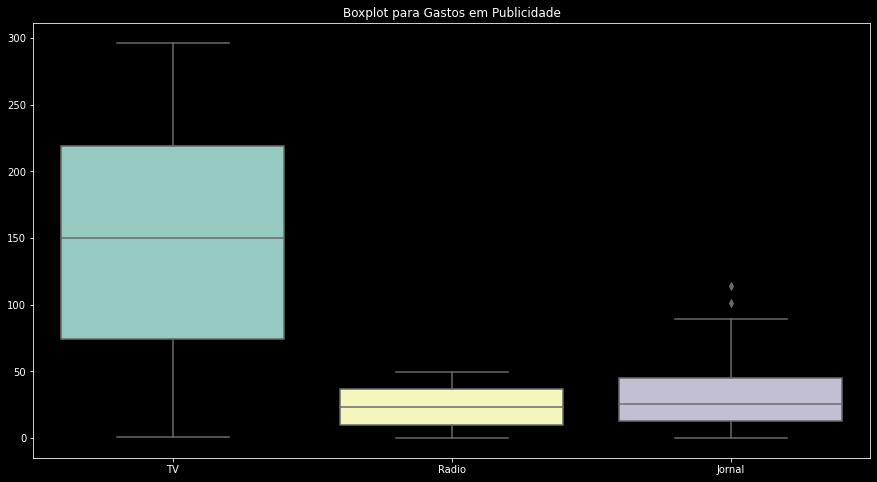

In [44]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=df[["TV", "Radio", "Jornal"]])
plt.title("Boxplot para Gastos em Publicidade")
plt.show()

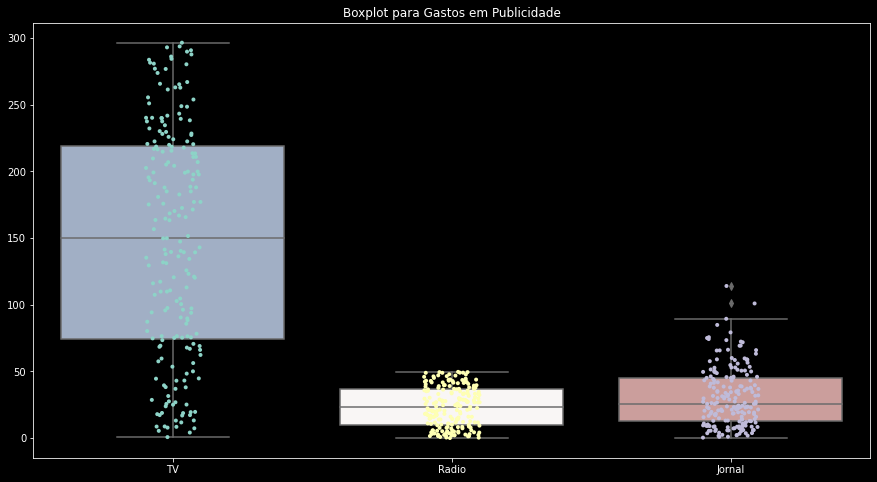

In [46]:
## mesmo grafico porem visão diferente
plt.figure(figsize=(15, 8))
sns.boxplot(data=df[["TV", "Radio", "Jornal"]], palette="vlag")
sns.stripplot(data=df[["TV", "Radio", "Jornal"]], size=4)
plt.title("Boxplot para Gastos em Publicidade")
plt.show()

<Figure size 1080x576 with 0 Axes>

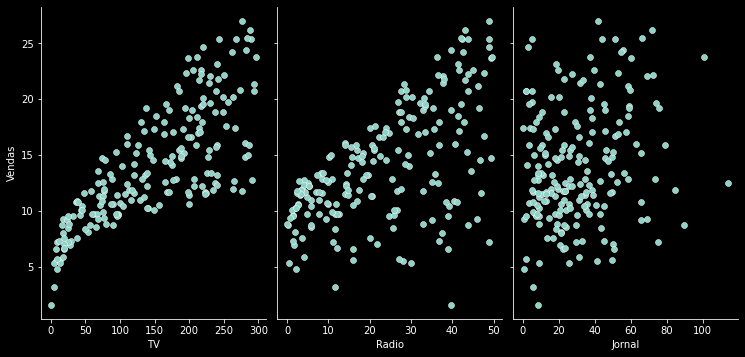

In [33]:
## Verificando as relacoes entre os dados
plt.figure(figsize=(15, 8))
sns.pairplot(
    df,
    x_vars=["TV", "Radio", "Jornal"],
    y_vars="Vendas",
    height=5,
    aspect=0.7,
)
plt.show()

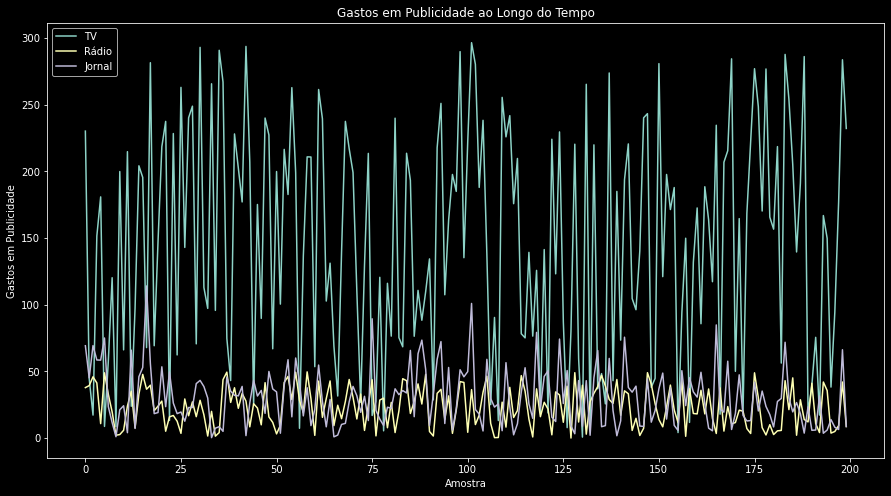

In [27]:
plt.figure(figsize=(15, 8))
plt.plot(df["TV"], label="TV")
plt.plot(df["Radio"], label="Rádio")
plt.plot(df["Jornal"], label="Jornal")
plt.title("Gastos em Publicidade ao Longo do Tempo")
plt.xlabel("Amostra")
plt.ylabel("Gastos em Publicidade")
plt.legend()
plt.show()

Analisando os graficos de densidade conseguimos ver que teve muito mais gastos em Tv. E em Jornal e Radio teve um pico maior significa que teve maior implicação de vendas em determinado momento.

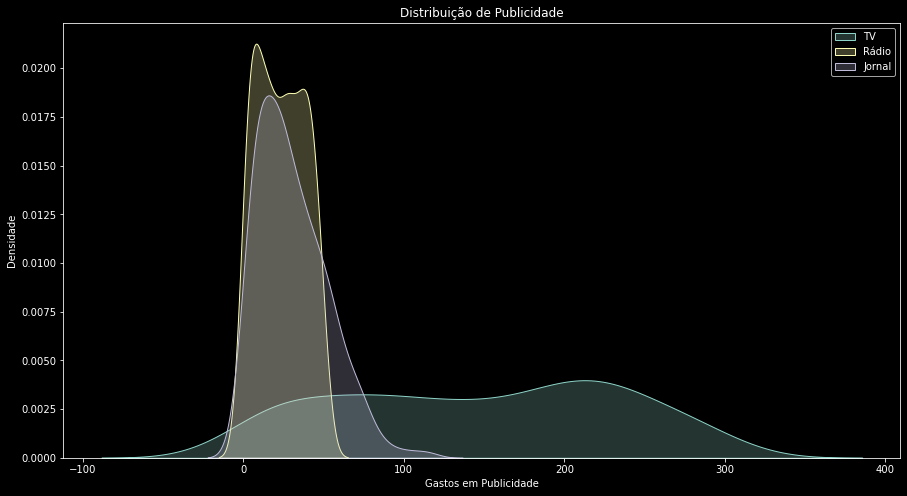

In [59]:
## Gráfico de densidade
plt.figure(figsize=(15, 8))
sns.kdeplot(df["TV"], label="TV", shade=True)
sns.kdeplot(df["Radio"], label="Rádio", shade=True)
sns.kdeplot(df["Jornal"], label="Jornal", shade=True)
plt.title("Distribuição de Publicidade")
plt.xlabel("Gastos em Publicidade")
plt.ylabel("Densidade")
plt.legend()
plt.show()

Optando por isso resolvi colocar as três variaveis uma em relação a outra para analizar seus respectivos planos.

In [65]:
# Crie um gráfico 3D
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=df["TV"],
            y=df["Vendas"],
            z=df["Radio"],
            mode="markers",
            marker=dict(size=15, color=df["Vendas"], colorscale="Viridis", opacity=0.9),
            text=df["Vendas"],
            hoverinfo="text+x+y+z",
        )
    ]
)


fig.update_layout(
    scene=dict(
        xaxis=dict(title="TV"),
        yaxis=dict(title="Vendas"),
        zaxis=dict(title="Radio"),
    ),
    title="Gráfico 3D de Vendas, TV, Rádio e Jornal",
)


fig.show()

Conseguimos notar um plano significativo para essas variaveis, que seria otima para fazer uma regressão multiplas.

------

#### Calculando as correlações

In [66]:
correlacoes = df.corr(method="pearson")
correlacoes

,TV,Radio,Jornal,Vendas
TV,1.000000,0.054809,0.056648,0.782224
Radio,0.054809,1.000000,0.354104,0.576223
Jornal,0.056648,0.354104,1.000000,0.228299
Vendas,0.782224,0.576223,0.228299,1.000000


In [67]:
correlacoes[correlacoes > 0.6]

,TV,Radio,Jornal,Vendas
TV,1.000000,NaN,NaN,0.782224
Radio,NaN,1.0,NaN,NaN
Jornal,NaN,NaN,1.0,NaN
Vendas,0.782224,NaN,NaN,1.000000


<AxesSubplot:>

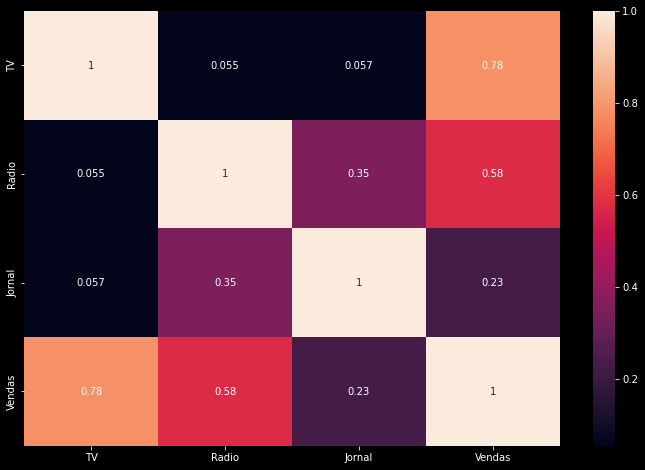

In [70]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlacoes, annot=True)

Conseguimos notar que aonde tem maior correlação e nas vendas e Tv

In [75]:
cov_TV = df["TV"].cov(df["Vendas"])
cov_Jornal = df["Jornal"].cov(df["Vendas"])
cov_Radio = df["Radio"].cov(df["Vendas"])

print(f"Covariancia da TV e Vendas e : {cov_TV}")
print(f"Covariancia da Jornal e Vendas e : {cov_Jornal}")
print(f"Covariancia da Radio e Vendas e : {cov_Radio}")

Covariancia da TV e Vendas e : 350.3901947236182
Covariancia da Jornal e Vendas e : 25.941391959799002
Covariancia da Radio e Vendas e : 44.635688442211055


-----

In [88]:
dict_save = {}

In [93]:
for i in df[["TV", "Radio", "Jornal"]]:
    print(i)

TV
Radio
Jornal


In [106]:
## Dividindo os dados para fazer a regressao para cada coluna


dict_save = dict()

for i in df[["TV", "Radio", "Jornal"]]:
    X = df[[i]]
    y = df["Vendas"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    dict_save[i] = {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
    }

In [113]:
dict_save["Radio"]["X_train"]

,Radio
79,7.7
197,9.3
38,26.7
24,12.6
122,2.4
...,...
106,11.0
14,32.9
92,33.5
179,10.0


In [116]:
for i in dict_save:
    print(dict_save[i])

{'X_train':         TV
79   116.0
197  177.0
38    43.1
24    62.3
122  224.0
..     ...
106   25.0
14   204.1
92   217.7
179  165.6
102  280.2

[160 rows x 1 columns], 'X_test':         TV
95   163.3
15   195.4
30   292.9
158   11.7
128  220.3
115   75.1
69   216.8
170   50.0
174  222.4
45   175.1
66    31.5
182   56.2
165  234.5
78     5.4
186  139.5
177  170.2
56     7.3
152  197.6
82    75.3
68   237.4
124  229.5
16    67.8
148   38.0
93   250.9
65    69.0
60    53.5
84   213.5
67   139.3
125   87.2
132    8.4
9    199.8
18    69.2
55   198.9
75    16.9
150  280.7
104  238.2
135   48.3
137  273.7
164  117.2
76    27.5, 'y_train': 79     11.0
197    12.8
38     10.1
24      9.7
122    11.6
       ... 
106     7.2
14     19.0
92     19.4
179    12.6
102    14.8
Name: Vendas, Length: 160, dtype: float64, 'y_test': 95     16.9
15     22.4
30     21.4
158     7.3
128    24.7
115    12.6
69     22.3
170     8.4
174    11.5
45     14.9
66      9.5
182     8.7
165    11.9
78      5.3
186  

Fazendo os modelos usando sklearn

In [118]:

def fit_linear_regression(dict_save):
    for feature in dict_save:
        X_train = dict_save[feature]["X_train"]
        y_train = dict_save[feature]["y_train"]
        X_test = dict_save[feature]["X_test"]
        y_test = dict_save[feature]["y_test"]

        model = LinearRegression()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        residuo = y_test - y_pred

        sqr_error = mean_squared_error(y_test, y_pred)

        dict_save[feature]["y_pred"] = y_pred
        dict_save[feature]["residuo"] = residuo
        dict_save[feature]["mean_squared_error"] = sqr_error
        dict_save[feature]["intercept"] = model.intercept_
        dict_save[feature]["coef"] = model.coef_[0]

        print(f"Modelo de Regressão para {feature}:")
        print(f"Coeficiente: {model.coef_[0]}")
        print(f"Intercepto: {model.intercept_}")
        print(f"Erro Quadrático Médio: {sqr_error}\n")
        print(f"Residuo {residuo}:")

    return dict_save


dict_result = fit_linear_regression(dict_save)

Modelo de Regressão para TV:
Coeficiente: 0.04652973370544335
Intercepto: 7.1196384305929525
Erro Quadrático Médio: 10.204654118800956

Residuo 95     2.182056
15     6.188452
30     0.651803
158   -0.364036
128    7.329861
115    1.985979
69     5.092715
170   -1.046125
174   -5.967851
45    -0.366995
66     0.914675
182   -1.034609
165   -6.130861
78    -2.070899
186   -3.310536
177   -3.338999
56    -1.959305
152    0.286086
82     0.676673
68     0.734203
124    1.901788
16     2.225646
148    2.012232
93     3.406051
65    -1.030190
60    -1.508979
84     4.646263
67    -0.201230
125   -0.577031
132   -1.810488
9     -5.816279
18     0.960504
55     7.325598
75     0.794009
150   -4.080535
104    2.496979
135    2.232975
137    0.945173
164   -0.672923
76    -1.499206
Name: Vendas, dtype: float64:
Modelo de Regressão para Radio:
Coeficiente: 0.20440684572929288
Intercepto: 9.424065649663843
Erro Quadrático Médio: 23.248766588129108

Residuo 95      1.016678
15      3.225728
30    

In [120]:
dict_result ## agora temos um dicionario para todos os modelos para cada coluna

{'TV': {'X_train':         TV
  79   116.0
  197  177.0
  38    43.1
  24    62.3
  122  224.0
  ..     ...
  106   25.0
  14   204.1
  92   217.7
  179  165.6
  102  280.2
  
  [160 rows x 1 columns],
  'X_test':         TV
  95   163.3
  15   195.4
  30   292.9
  158   11.7
  128  220.3
  115   75.1
  69   216.8
  170   50.0
  174  222.4
  45   175.1
  66    31.5
  182   56.2
  165  234.5
  78     5.4
  186  139.5
  177  170.2
  56     7.3
  152  197.6
  82    75.3
  68   237.4
  124  229.5
  16    67.8
  148   38.0
  93   250.9
  65    69.0
  60    53.5
  84   213.5
  67   139.3
  125   87.2
  132    8.4
  9    199.8
  18    69.2
  55   198.9
  75    16.9
  150  280.7
  104  238.2
  135   48.3
  137  273.7
  164  117.2
  76    27.5,
  'y_train': 79     11.0
  197    12.8
  38     10.1
  24      9.7
  122    11.6
         ... 
  106     7.2
  14     19.0
  92     19.4
  179    12.6
  102    14.8
  Name: Vendas, Length: 160, dtype: float64,
  'y_test': 95     16.9
  15     22.4
  30  

In [122]:
dict_result["TV"]["residuo"].max()

7.329861234097876

In [123]:
dict_result["TV"]["residuo"].min()

-6.130860984519417

Aparentemente o modelo não teve um bom desemprenho

In [ ]:
dict_result

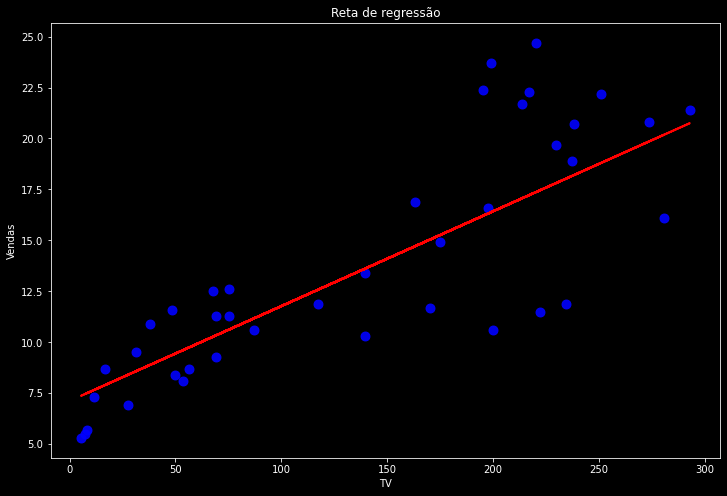

In [182]:
# Resetar os índices para garantir que sejam sequenciais
X_test = dict_result["TV"]["X_test"].reset_index(drop=True)
y_test = dict_result["TV"]["y_test"].reset_index(drop=True)

# Converter séries para arrays numpy
X_test_array = X_test.values
y_test_array = y_test.values

y_pred = dict_result["TV"]["y_pred"]

# Plotar os dados
plt.figure(figsize=(12, 8))
plt.scatter(
    x=X_test_array,
    y=y_test_array,
    color="blue",
    s=80,
    alpha=0.9,
)
plt.plot(X_test_array, y_pred, color="red", linewidth=2)
plt.title("Reta de regressão")
plt.ylabel("Vendas")
plt.xlabel("TV")
plt.show()

In [183]:
residuos = dict_result["TV"]["residuo"].values

estatistica, p = shapiro(residuos)
print("Estatística de teste: {}".format(estatistica))
print("p-valor: {}".format(p))

Estatística de teste: 0.9700982570648193
p-valor: 0.3624991476535797


-----

In [184]:
dict_result["TV"]["X_test"].values

array([[163.3],
       [195.4],
       [292.9],
       [ 11.7],
       [220.3],
       [ 75.1],
       [216.8],
       [ 50. ],
       [222.4],
       [175.1],
       [ 31.5],
       [ 56.2],
       [234.5],
       [  5.4],
       [139.5],
       [170.2],
       [  7.3],
       [197.6],
       [ 75.3],
       [237.4],
       [229.5],
       [ 67.8],
       [ 38. ],
       [250.9],
       [ 69. ],
       [ 53.5],
       [213.5],
       [139.3],
       [ 87.2],
       [  8.4],
       [199.8],
       [ 69.2],
       [198.9],
       [ 16.9],
       [280.7],
       [238.2],
       [ 48.3],
       [273.7],
       [117.2],
       [ 27.5]])

In [185]:
dict_result["TV"]["y_test"].T

95     16.9
15     22.4
30     21.4
158     7.3
128    24.7
115    12.6
69     22.3
170     8.4
174    11.5
45     14.9
66      9.5
182     8.7
165    11.9
78      5.3
186    10.3
177    11.7
56      5.5
152    16.6
82     11.3
68     18.9
124    19.7
16     12.5
148    10.9
93     22.2
65      9.3
60      8.1
84     21.7
67     13.4
125    10.6
132     5.7
9      10.6
18     11.3
55     23.7
75      8.7
150    16.1
104    20.7
135    11.6
137    20.8
164    11.9
76      6.9
Name: Vendas, dtype: float64

In [204]:
df_t = pd.DataFrame(dict_result)
df_t.TV.X_test

,TV
95,163.3
15,195.4
30,292.9
158,11.7
128,220.3
115,75.1
69,216.8
170,50.0
174,222.4
45,175.1


In [205]:
df_t.TV.y_test

95     16.9
15     22.4
30     21.4
158     7.3
128    24.7
115    12.6
69     22.3
170     8.4
174    11.5
45     14.9
66      9.5
182     8.7
165    11.9
78      5.3
186    10.3
177    11.7
56      5.5
152    16.6
82     11.3
68     18.9
124    19.7
16     12.5
148    10.9
93     22.2
65      9.3
60      8.1
84     21.7
67     13.4
125    10.6
132     5.7
9      10.6
18     11.3
55     23.7
75      8.7
150    16.1
104    20.7
135    11.6
137    20.8
164    11.9
76      6.9
Name: Vendas, dtype: float64

In [214]:
df

,TV,Radio,Jornal,Vendas
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9
...,...,...,...,...
195,38.2,3.7,13.8,7.6
196,94.2,4.9,8.1,9.7
197,177.0,9.3,6.4,12.8
198,283.6,42.0,66.2,25.5


In [215]:
df_treino, df_test = train_test_split(df, test_size=0.2, random_state=42)

regressao = smf.ols("TV ~ Vendas", data=df_treino).fit()


In [216]:
residuos = regressao.resid
residuos

79       5.366559
197     43.497307
38     -56.098815
24     -31.816759
122    105.743475
          ...    
106    -37.353909
14      -8.174561
92       0.343383
179     34.638335
102    121.287027
Length: 160, dtype: float64

In [217]:
estatistica, p = shapiro(residuos)
print("Estatística de teste: {}".format(estatistica))
print("p-valor: {}".format(p))

Estatística de teste: 0.9369369149208069
p-valor: 1.58428542818001e-06


In [218]:
outliers = regressao.outlier_test()

In [219]:
outliers.max()

student_resid    2.984831
unadj_p          0.998773
bonf(p)          1.000000
dtype: float64

In [220]:
outliers.min()

student_resid   -1.543355
unadj_p          0.003292
bonf(p)          0.526705
dtype: float64

In [221]:
print(regressao.summary())

                            OLS Regression Results                            
Dep. Variable:                     TV   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     228.5
Date:                Mon, 11 Dec 2023   Prob (F-statistic):           1.68e-32
Time:                        20:45:12   Log-Likelihood:                -864.70
No. Observations:                 160   AIC:                             1733.
Df Residuals:                     158   BIC:                             1740.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -29.1231     12.601     -2.311      0.0

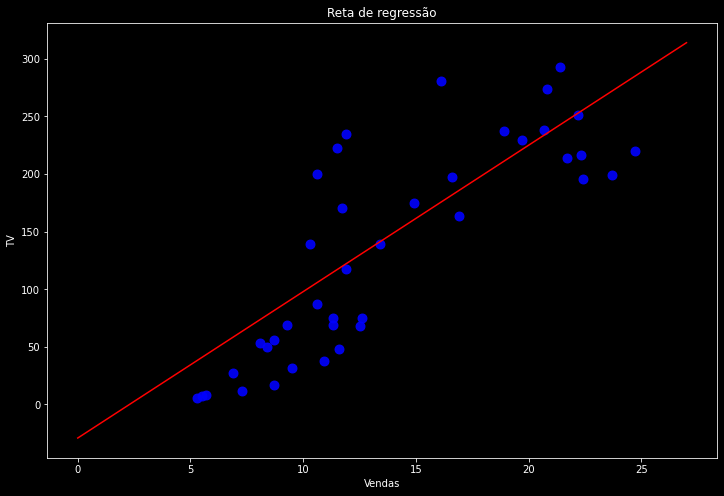

In [224]:
plt.figure(figsize=(12, 8))
plt.scatter(y=df_test.TV, x=df_test.Vendas, color="blue", s=80, alpha=0.9)
X_plot = np.linspace(0, 27)
plt.plot(X_plot, X_plot * regressao.params[1] + regressao.params[0], color="r")
plt.title("Reta de regressão")
plt.ylabel("TV")
plt.xlabel("Vendas")
plt.show()

Dividi os dados nos mesmo 20% para treino e 80% teste porem aparentemente para esses dados fazendo a regressão estatistica e a regressão de machine learning a de estatistica teve menos residuos 